<a href="https://colab.research.google.com/github/nightted/ML-LeeHongYi-HW/blob/master/HW3_CNN_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

In [ ]:
!pip install GPUtil


  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=147b4f3cbb6a34c8e8b77c09cf1f004296d6a8cb09e27a5728ea18f34c02bb03
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
def GPU_usage():
  import GPUtil
  GPUs = GPUtil.getGPUs()
  for i , gpu in enumerate(GPUs):
    print("MemoryUsing:",gpu.memoryTotal-gpu.memoryFree,"MemoryTotal:",gpu.memoryTotal,"memoryUtilization:",gpu.memoryUtil*100,"%")

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集
!unzip food-11.zip # 解壓縮

Streaming output truncated to the last 5000 lines.
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  inflating: food-11/

In [ ]:
test_path = './food-11/training'
test_img = sorted(os.listdir(test_path))[1]
img = cv2.imread(os.path.join(test_path,test_img))

In [ ]:
img.shape #check the shape of img

(512, 512, 3)

In [ ]:
resize_img = cv2.resize(img,(128,128))
print(type(resize_img),resize_img.shape)

<class 'numpy.ndarray'> (128, 128, 3)


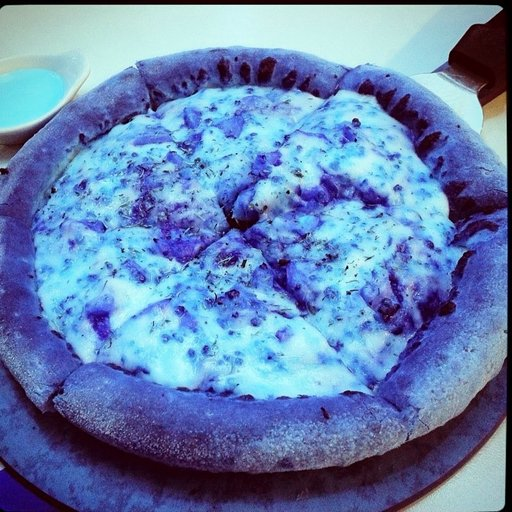

In [ ]:
from PIL import Image
Image.fromarray(img,"RGB")

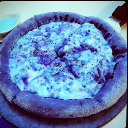

In [ ]:
Image.fromarray(resize_img,"RGB")

In [ ]:
#check the size of img
Img_path = './food-11'
path_training = os.path.join(Img_path,'training')
path_validate = os.path.join(Img_path,'validation')
path_test = os.path.join(Img_path,'testing')

size_training = len(os.listdir(path_training))
size_validate = len(os.listdir(path_validate))
size_test = len(os.listdir(path_test))

print("size of training:",size_training)
print("size of validate:",size_validate)
print("size of test:",size_test)

size of training: 9866
size of validate: 3430
size of test: 3347


In [ ]:
#Create the array to store the img
img_size = 128
train_x ,train_y = np.zeros((size_training,img_size,img_size,3),dtype=np.uint8) , np.zeros((size_training),dtype=np.uint8)
validate_x ,validate_y = np.zeros((size_validate,img_size,img_size,3),dtype=np.uint8) ,np.zeros((size_validate),dtype=np.uint8)
test_x  = np.zeros((size_test,img_size,img_size,3),dtype=np.uint8)

#function to transfer the img to the data array
def img_process(path, data_x = None ,data_y = None,label = None):

  img_list  = sorted(os.listdir(path))
  label = bool(path.split("/")[2] != "testing")
 
  for idx , img_dir in enumerate(img_list):
    img = cv2.imread(os.path.join(path,img_dir))
    data_x[idx , : , : , :] = cv2.resize(img,(img_size,img_size))

    if label:
      data_y[idx] = int(img_dir.split("_")[0])

  if label :
    return data_x , data_y
  else: 
    return data_x 




In [ ]:
#Implement
train_x, train_y = img_process(path_training,train_x,train_y)
validate_x ,validate_y = img_process(path_validate,validate_x,validate_y)
test_x = img_process(path_test,test_x)

In [ ]:
print("shape of training:",train_x.shape , train_y.shape)
print("shape of validate:",validate_x.shape ,validate_y.shape)
print("shape of test:",test_x.shape)

shape of training: (9866, 128, 128, 3) (9866,)
shape of validate: (3430, 128, 128, 3) (3430,)
shape of test: (3347, 128, 128, 3)


1.Why augmentation? 

https://chtseng.wordpress.com/2017/11/11/data-augmentation-%E8%B3%87%E6%96%99%E5%A2%9E%E5%BC%B7/

2.Image Need Normalize?

3.Dataset & Dataloader? 

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Data Augmetation 

In [ ]:
train_trasformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
test_trasformer = transforms.Compose([
    # No need to do trnasform to test data!
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class ImgDataSet(Dataset):

  def __init__(self , x , y = None , transform = None ):

    self.x = x 
    self.y = y
    if y is not None :
      self.y = torch.LongTensor(y)

    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self,index):

    X = self.x[index]
    if self.transform is not None:
      X = self.transform(X)
    if self.y is not None:
      Y = self.y[index]
      return X, Y

    else : 
      return X

# Consturct Network

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        # out.size[0] dimension is the "size of dataset"
        # so this tensor shape is [size of data set , 512*4*4] 
        out = out.view(out.size()[0], -1)
        return self.fc(out)
        

# Set up the training data and model,loss,optimizer,parameter 

In [ ]:
#params :
lr = 0.001
epoch = 25
batch_size = 150
#Training setup 
train_set = ImgDataSet(train_x, train_y ,train_trasformer)
validate_set = ImgDataSet(validate_x ,validate_y ,train_trasformer)
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_set , batch_size=batch_size , shuffle=False)
model = Classifier().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

#Training 

In [ ]:
train_loss = []
validate_loss = []
train_acc = []
validate_acc = []

for epoch in range(epoch):

    model.train()
    count = batch_size # monitor the size
    for i , data in enumerate(train_loader):
      
      #print("After dataloader:",train_set[0][0],"before dataloader:",train_x.shape)
      #Set the train data into GPU
      Train_X = data[0].cuda()
      Train_Y = data[1].cuda()
      optimizer.zero_grad() #clean the gradient 
      train_pred = model(Train_X)  
      loss = criterion(train_pred,Train_Y) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
      #print(count)
      loss.backward()
      optimizer.step()
      count+=128

    #Turn off the Batch-norm and drop-out tracking while validating
    model.eval()
    #Turn off the gradient tracking while validating
    with torch.no_grad():

    #Do the full-epoch evaluation
    #DON'T Put full-epoch once in the GPU , it'll exploded XDDDDD
    
      #Training Part
      loss_train , acc_train = 0 , 0
      for i ,train_data in enumerate(train_loader):
        
        Train_X = train_data[0].cuda()
        Train_Y = train_data[1].cuda()
        train_pred = model(Train_X)
        loss_train += criterion(train_pred,Train_Y).item()
        acc_train += np.sum(np.argmax(train_pred.cpu().numpy(),axis=1) == Train_Y.cpu().numpy()) 
        #print("loss_train now:",loss_train,"acc_train now:",acc_train)

      #Record Train loss 
      train_loss.append(loss_train/train_set.__len__())
      train_acc.append(acc_train/train_set.__len__())


      #Validate Part
      loss_val , acc_val = 0 , 0
      for i ,val_data in enumerate(validate_loader):

        Vali_X = val_data[0].cuda()
        Vali_Y = val_data[1].cuda()
        vali_pred = model(Vali_X)
        loss_val += criterion(vali_pred,Vali_Y).item()
        acc_val += np.sum(np.argmax(vali_pred.cpu().numpy(),axis=1) == Vali_Y.cpu().numpy())
        #print("loss_val now:",loss_val,"acc_val now:",acc_val)

      #Record Validate loss
      validate_loss.append(loss_val/validate_set.__len__())
      validate_acc.append(acc_val/validate_set.__len__())
       
      print("loss_train:",train_loss[-1],"acc_train:",train_acc[-1],"loss_validate:",validate_loss[-1],"acc_validate:",validate_acc[-1])







loss_train: 0.015021325583489845 acc_train: 0.20231096695722683 loss_validate: 0.015121180392562822 acc_validate: 0.19387755102040816
loss_train: 0.012515219005106817 acc_train: 0.35201702817757957 loss_validate: 0.01253905921913792 acc_validate: 0.3396501457725947
loss_train: 0.013896233782235638 acc_train: 0.3437056557875532 loss_validate: 0.01399426844307702 acc_validate: 0.3306122448979592
loss_train: 0.012230560561113804 acc_train: 0.3640786539631056 loss_validate: 0.012520604752243087 acc_validate: 0.36064139941690965
loss_train: 0.009975922861665687 acc_train: 0.47841070342590714 loss_validate: 0.010238710089258132 acc_validate: 0.4728862973760933
loss_train: 0.011913949943521601 acc_train: 0.42986012568416787 loss_validate: 0.012374794048748628 acc_validate: 0.4198250728862974
loss_train: 0.011318416013549458 acc_train: 0.4393877964727346 loss_validate: 0.011966436840702423 acc_validate: 0.4282798833819242
loss_train: 0.009703944644313204 acc_train: 0.49736468680316237 loss_val

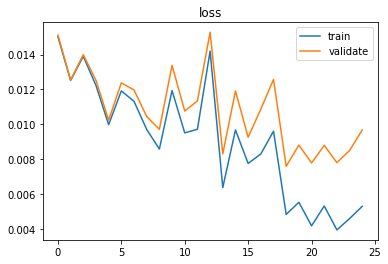

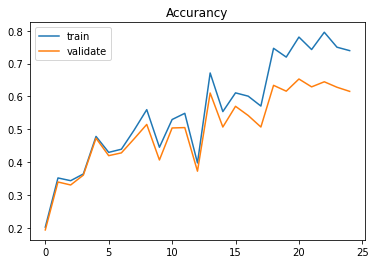

In [ ]:
import matplotlib.pyplot as plt

#Loss curve
plt.plot(train_loss)
plt.plot(validate_loss)
plt.title("loss")
plt.legend(["train","validate"])
plt.savefig("loss.png")
plt.show()

#Acc curve
plt.plot(train_acc)
plt.plot(validate_acc)
plt.title("Accurancy")
plt.legend(["train","validate"])
plt.savefig("acc.png")
plt.show()

In [ ]:
GPU_usage()